# May 20 - Train SimCLR

1. Train SimCLR network on ImageNet? for ~ 100 epochs. 
    - optimize model training
2. Train a classification block/layer for ~ 80 epochs. 
    - optimize model training
3. Evaluate performance on CXR task.

In [1]:
import os
import torch
import pickle
from models import *
from training import * 
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning.losses import NTXentLoss

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

# import os
class CIFAR10(Dataset): 

    def __init__(self, mode = 'train'): 
        """ accepts mode train, val, or test"""
        super().__init__()
        self.mode = mode
        
        # unpickle data
        os.chdir('/home/sshad/data/wcl-data')
        self.images = unpickle(f'{self.mode}_images')
        self.labels = unpickle(f'{self.mode}_labels') 

        ## SimCLR transformations
        if mode == 'train': 
            self.transforms = A.Compose([
            A.RandomResizedCrop(height=28, width=28), #28 * 28 (no resize) [previously 224 * 224]
            A.HorizontalFlip(),
            A.ColorJitter(p=0.8, brightness=0.8, 
                        contrast=0.8, saturation=0.8, hue=0.2),
            A.ToGray(p=0.2),
            A.GaussianBlur(sigma_limit=(0.1, 2.0)),
            A.Normalize()
            ])
        else: 
            self.transforms = A.Compose([ 
                A.CenterCrop(height=28, width=28), # 28 * 28 from 224 * 224
                A.Normalize()
            ])

    def __len__(self): 
        return len(self.images)
    
    def __getitem__(self, index): 
        
        image, label = self.images[index], self.labels[index]
        image = image.reshape(3, 32, 32).transpose() #transpose for augmentation
        if self.mode != 'test': 
            img1 = self.transforms(image=image)['image'].transpose()
            img2 = self.transforms(image=image)['image'].transpose()
            return img1, img2, label
        else: 
            image = self.transforms(image=image)['image'].transpose()
            return label

## Test: How long is model training with all simclr agumentations?

In [1]:
BATCH_SIZE = 10  # 5 mins per epoch with batch size 10 without all transforms..
train_data = CIFAR10()
val_data = CIFAR10(mode = 'val')
train_dl = DataLoader(train_data, BATCH_SIZE)
val_dl = DataLoader(val_data, BATCH_SIZE)

NameError: name 'CIFAR10' is not defined

In [ ]:
pretrain = SimCLR().to(device)
criterion = NTXentLoss(temperature=0.1).to(device)
optimizer = torch.optim.Adam(pretrain.parameters())

In [ ]:
model_train(train_dataloader = train_dl, 
            val_dataloader = val_dl, 
            model = pretrain, 
            criterion = criterion, 
            optimizer = optimizer, 
            epochs = 2,
            device = device) # 8m 35.7s
# This takes roughly 4-5 mins again

Epoch: 1/2 	 T Loss: 2.8624          	 V Loss: 1.9894
Epoch: 2/2 	 T Loss: 2.7227          	 V Loss: 1.9986


## Test: How long is model training with larger batch sizes? 

##### BATCH SIZE 100

In [11]:
BATCH_SIZE = 100  # 5 mins per epoch with batch size 10 
train_data = CIFAR10()
val_data = CIFAR10(mode = 'val')
train_dl = DataLoader(train_data, BATCH_SIZE)
val_dl = DataLoader(val_data, BATCH_SIZE)

In [12]:
model_train(train_dataloader = train_dl, 
            val_dataloader = val_dl, 
            model = pretrain, 
            criterion = criterion, 
            optimizer = optimizer, 
            epochs = 2,
            device = device) # 2m 40.0s

# This takes only ~ 1-2 min or so.
# Better time. Interestingly, higher loss.

Epoch: 1/2 	 T Loss: 4.9890          	 V Loss: 4.1682
Epoch: 2/2 	 T Loss: 4.9369          	 V Loss: 4.0569


##### BATCH SIZE 200

In [13]:
BATCH_SIZE = 200 # 1-2 mins per epoch with batch size 100
train_data = CIFAR10()
val_data = CIFAR10(mode = 'val')
train_dl = DataLoader(train_data, BATCH_SIZE)
val_dl = DataLoader(val_data, BATCH_SIZE)

In [16]:
model_train(train_dataloader = train_dl, 
            val_dataloader = val_dl, 
            model = pretrain, 
            criterion = criterion, 
            optimizer = optimizer, 
            epochs = 2,
            device = device) # 2m 22.1s, 2m 30.5s

# 10 second gain. Even slightly higher loss.

Epoch: 1/2 	 T Loss: 5.3841          	 V Loss: 4.0287
Epoch: 2/2 	 T Loss: 5.2350          	 V Loss: 3.7711


##### BATCH SIZE 128

Used in one online implementation

In [17]:
BATCH_SIZE = 128
train_data = CIFAR10()
val_data = CIFAR10(mode = 'val')
train_dl = DataLoader(train_data, BATCH_SIZE)
val_dl = DataLoader(val_data, BATCH_SIZE)

In [20]:
model_train(train_dataloader = train_dl, 
            val_dataloader = val_dl, 
            model = pretrain, 
            criterion = criterion, 
            optimizer = optimizer, 
            epochs = 2,
            device = device) # 2m 35s

Epoch: 1/2 	 T Loss: 5.4470          	 V Loss: 4.8639
Epoch: 2/2 	 T Loss: 5.3168          	 V Loss: 4.6175


## Pre-train SimCLR R1 

*BS* 128  
*Epochs* 100  
*Criterion* NTXentLoss, temperature:0.1  
*Optimizer* Adam, default parameters  

**Made changes to training.py to save losses for visualization** 
So, previous code cells won't work. 

In [5]:
BATCH_SIZE = 128
train_data = CIFAR10()
val_data = CIFAR10(mode = 'val')
train_dl = DataLoader(train_data, BATCH_SIZE)
val_dl = DataLoader(val_data, BATCH_SIZE)

In [6]:
simclr_r1 = SimCLR().to(device)
criterion = NTXentLoss(temperature=0.1).to(device)
optimizer = torch.optim.Adam(simclr_r1.parameters())

In [7]:
train_losses, val_losses = model_train(train_dataloader = train_dl, 
            val_dataloader = val_dl, 
            model = simclr_r1, 
            criterion = criterion, 
            optimizer = optimizer, 
            epochs = 100,
            device = device)

Epoch: 1/100 	 T Loss: 5.4180          	 V Loss: 4.8045
Epoch: 2/100 	 T Loss: 5.3028          	 V Loss: 4.7896
Epoch: 3/100 	 T Loss: 5.2780          	 V Loss: 4.7973
Epoch: 4/100 	 T Loss: 5.2605          	 V Loss: 4.6668
Epoch: 5/100 	 T Loss: 5.1931          	 V Loss: 4.1991
Epoch: 6/100 	 T Loss: 5.0990          	 V Loss: 4.0730
Epoch: 7/100 	 T Loss: 4.9327          	 V Loss: 3.5040
Epoch: 8/100 	 T Loss: 4.7732          	 V Loss: 3.2464
Epoch: 9/100 	 T Loss: 4.6193          	 V Loss: 2.9380
Epoch: 10/100 	 T Loss: 4.5180          	 V Loss: 2.8159
Epoch: 11/100 	 T Loss: 4.4271          	 V Loss: 2.6174
Epoch: 12/100 	 T Loss: 4.3128          	 V Loss: 2.2913
Epoch: 13/100 	 T Loss: 4.2254          	 V Loss: 2.0557
Epoch: 14/100 	 T Loss: 4.1481          	 V Loss: 2.0106
Epoch: 15/100 	 T Loss: 4.0725          	 V Loss: 2.0165
Epoch: 16/100 	 T Loss: 4.0295          	 V Loss: 1.7054
Epoch: 17/100 	 T Loss: 3.9677          	 V Loss: 1.6818
Epoch: 18/100 	 T Loss: 3.9044          

### Save Model

In [12]:
def save_model(model, optimizer, name):
    out = os.path.join('/home/sshad/wcl-project/saved_models', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, out)

In [14]:
save_model(simclr_r1, optimizer, name = 'simclr_r1_may20')

In [16]:
simclr_duplicate = torch.load('/home/sshad/wcl-project/saved_models/simclr_r1_may20')

In [38]:
# import pandas as pd

r1_df = pd.DataFrame({
    'Training Loss': train_losses, 
    'Validation Loss': val_losses
})
r1_df.reset_index(inplace = True)
r1_df.rename(columns = {'index': 'Epochs'}, inplace = True)

In [48]:
os.chdir('/home/sshad/wcl-project/saved_models')
with open('simclr_r1_may20_losses', 'wb') as f:
        pickle.dump(r1_df, f)

### Visualize Losses

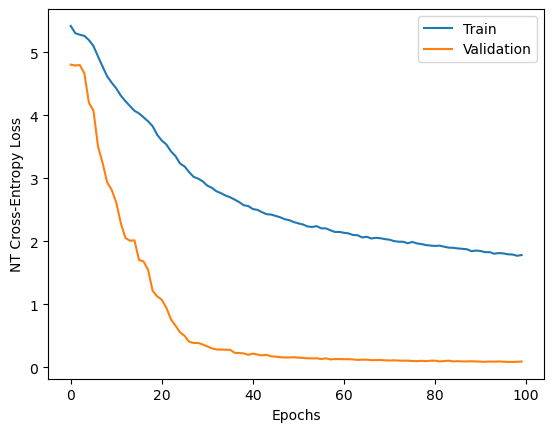

In [46]:
# import matplotlib.pyplot as plt
plt.figure()

plt.plot(r1_df['Epochs'], r1_df['Training Loss'], label = 'Train')
plt.plot(r1_df['Epochs'], r1_df['Validation Loss'], label = 'Validation')

plt.xlabel('Epochs')
plt.ylabel('NT Cross-Entropy Loss')
plt.legend()

plt.show()

## Linear Evaluation on CXR Data